# Lesson 8 — CLIP: Zero-Shot Vision-Language Understanding

This notebook explores OpenAI's CLIP (Contrastive Language-Image Pretraining) model.

**Topics covered:**
1. **Zero-Shot Classification**: Classify images into any categories without training.
2. **Prompt Engineering**: How text prompts affect classification accuracy.
3. **Image-Text Retrieval**: Search images with text queries (and vice versa).
4. **Contrastive Loss**: Implement the InfoNCE loss that powers CLIP.


In [1]:
# Install dependencies (uncomment and run if needed)
# !pip install git+https://github.com/openai/CLIP.git
# !pip install torch torchvision Pillow matplotlib requests numpy scikit-learn


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import clip
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Auto-detect device: MPS (Apple Silicon), CUDA, or CPU
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {device}")


PyTorch version: 2.6.0
Using device: mps


## 1. Loading CLIP

CLIP consists of two encoders:
- **Image Encoder**: Converts images to embeddings (ResNet or ViT)
- **Text Encoder**: Converts text to embeddings (Transformer)

Both produce vectors in the **same embedding space**, allowing direct comparison.


In [3]:
# List available CLIP models
print("Available CLIP models:")
print(clip.available_models())


Available CLIP models:
['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [4]:
# Load CLIP model (ViT-B/32 is a good balance of speed and accuracy)
model, preprocess = clip.load("ViT-B/32", device=device)
print(f"Model loaded successfully!")
print(f"Image input size: {model.visual.input_resolution}")
print(f"Embedding dimension: {model.visual.output_dim}")


Model loaded successfully!
Image input size: 224
Embedding dimension: 512


## 2. Helper Functions

Let's create utilities for loading images from URLs and displaying results.


In [5]:
def load_image_from_url(url):
    """Download and return a PIL Image from URL."""
    response = requests.get(url, timeout=10)
    return Image.open(BytesIO(response.content)).convert("RGB")

def show_image(image, title=None):
    """Display a PIL image."""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

def show_images_grid(images, titles=None, cols=4):
    """Display multiple images in a grid."""
    n = len(images)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    axes = axes.flatten() if n > 1 else [axes]
    
    for i, ax in enumerate(axes):
        if i < n:
            ax.imshow(images[i])
            if titles and i < len(titles):
                ax.set_title(titles[i], fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


## 3. Sample Images

Let's load a diverse set of sample images for our experiments.


In [6]:
# Sample image URLs (from Unsplash - free to use)
image_urls = {
    "cat": "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=400",
    "dog": "https://images.unsplash.com/photo-1587300003388-59208cc962cb?w=400",
    "car": "https://images.unsplash.com/photo-1494976388531-d1058494ceb8?w=400",
    "airplane": "https://images.unsplash.com/photo-1436491865332-7a61a109cc05?w=400",
    "beach": "https://images.unsplash.com/photo-1507525428034-b723cf961d3e?w=400",
    "mountain": "https://images.unsplash.com/photo-1464822759023-fed622ff2c3b?w=400",
    "food": "https://images.unsplash.com/photo-1567620905732-2d1ec7ab7445?w=400",
    "city": "https://images.unsplash.com/photo-1477959858617-67f85cf4f1df?w=400",
}

# Download images
print("Downloading sample images...")
images = {}
for name, url in image_urls.items():
    try:
        images[name] = load_image_from_url(url)
        print(f"  ✓ {name}")
    except Exception as e:
        print(f"  ✗ {name}: {e}")

print(f"\nLoaded {len(images)} images.")


  ✓ cat
  ✓ dog
  ✗ car: cannot identify image file <_io.BytesIO object at 0x11b1c1d00>
  ✓ airplane
  ✓ beach
  ✓ mountain
  ✓ food
  ✓ city

Loaded 7 images.


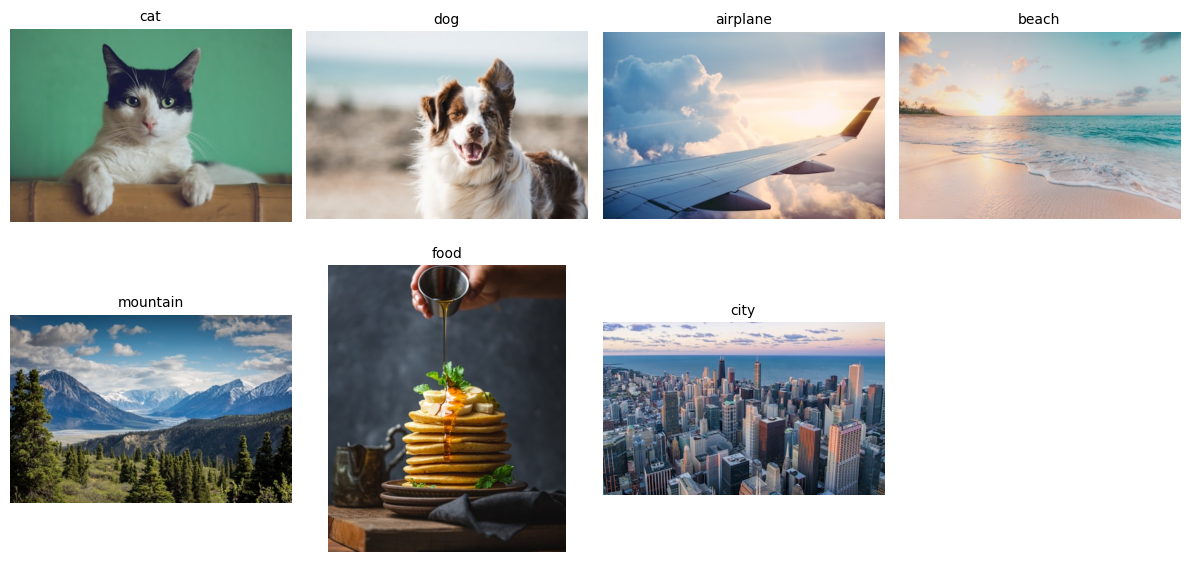

In [7]:
# Display all sample images
show_images_grid(
    list(images.values()), 
    titles=list(images.keys()),
    cols=4
)


## 4. Zero-Shot Image Classification

CLIP can classify images into **any categories** without training — just by comparing image embeddings to text embeddings of class labels.

This is called **zero-shot** because the model never saw these specific classes during training.


In [8]:
def classify_image(image, labels, top_k=3):
    """
    Zero-shot classify an image into given labels.
    
    Args:
        image: PIL Image
        labels: List of text labels (e.g., ["a cat", "a dog", "a car"])
        top_k: Number of top predictions to return
    
    Returns:
        List of (label, probability) tuples
    """
    # Preprocess image
    image_input = preprocess(image).unsqueeze(0).to(device)
    
    # Tokenize text labels
    text_inputs = clip.tokenize(labels).to(device)
    
    # Encode both modalities
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)
        
        # Normalize embeddings
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
        # Compute cosine similarity (scaled by temperature)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    
    # Get top predictions
    probs = similarity[0].cpu().numpy()
    top_indices = probs.argsort()[-top_k:][::-1]
    
    return [(labels[i], probs[i]) for i in top_indices]


In [9]:
# Define class labels (using the "a photo of a ..." prompt format)
class_labels = [
    "a photo of a cat",
    "a photo of a dog",
    "a photo of a car",
    "a photo of an airplane",
    "a photo of a beach",
    "a photo of a mountain",
    "a photo of food",
    "a photo of a city",
]

# Classify each image
print("Zero-Shot Classification Results:")
print("=" * 60)

for name, image in images.items():
    predictions = classify_image(image, class_labels, top_k=3)
    print(f"\n{name.upper()}:")
    for label, prob in predictions:
        # Extract just the object name from the prompt
        short_label = label.replace("a photo of ", "").replace("an ", "").replace("a ", "")
        bar = "█" * int(prob * 30)
        print(f"  {short_label:12} {bar} {prob:.1%}")


Zero-Shot Classification Results:

CAT:
  cat          █████████████████████████████ 99.4%
  dog           0.5%
  food          0.0%

DOG:
  dog          █████████████████████████████ 98.8%
  beach         1.1%
  cat           0.1%

AIRPLANE:
  airplane     █████████████████████████████ 99.7%
  city          0.1%
  mountain      0.1%

BEACH:
  beach        █████████████████████████████ 99.8%
  city          0.1%
  airplane      0.0%

MOUNTAIN:
  mountain     █████████████████████████████ 98.4%
  city          0.7%
  beach         0.4%

FOOD:
  food         █████████████████████████████ 99.4%
  mountain      0.5%
  cat           0.0%

CITY:
  city         █████████████████████████████ 99.1%
  beach         0.5%
  airplane      0.2%


### Visualize Classification Confidence

Let's create a visual comparison of predictions for all images.


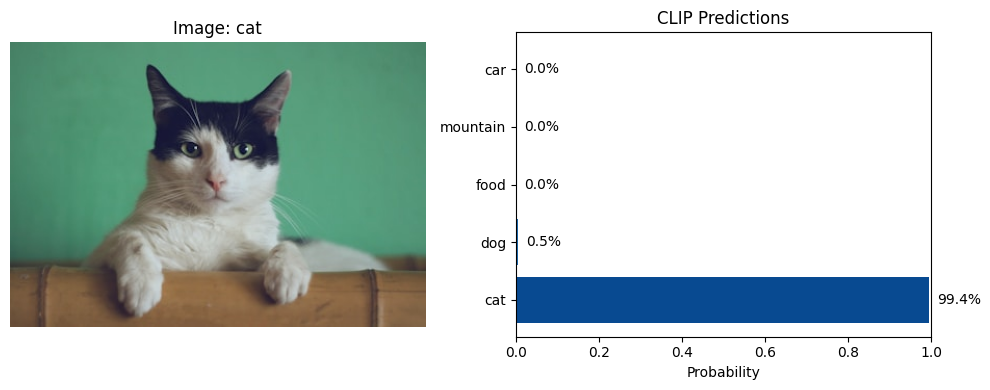

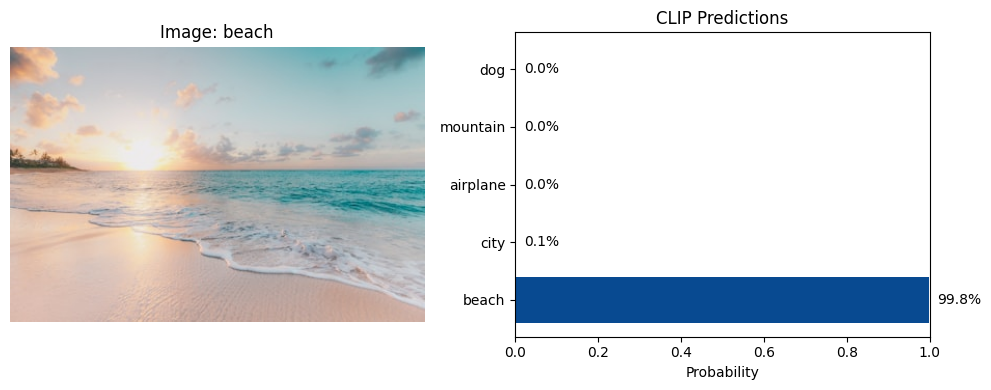

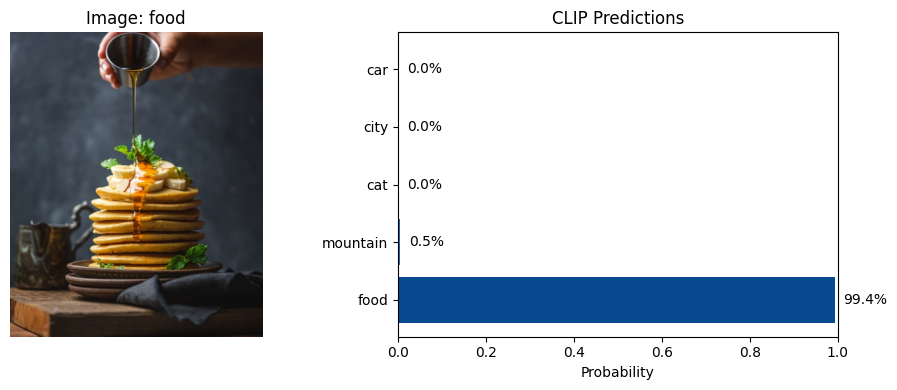

In [10]:
def visualize_classification(image, predictions, title=""):
    """Show image alongside bar chart of predictions."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Show image
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title(title)
    
    # Show predictions as horizontal bar chart
    labels = [p[0].replace("a photo of ", "").replace("an ", "").replace("a ", "") for p in predictions]
    probs = [p[1] for p in predictions]
    colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(labels)))
    
    y_pos = np.arange(len(labels))
    ax2.barh(y_pos, probs, color=colors[::-1])
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(labels)
    ax2.set_xlabel('Probability')
    ax2.set_xlim(0, 1)
    ax2.set_title('CLIP Predictions')
    
    # Add probability labels on bars
    for i, prob in enumerate(probs):
        ax2.text(prob + 0.02, i, f'{prob:.1%}', va='center')
    
    plt.tight_layout()
    plt.show()

# Visualize a few examples
for name in ["cat", "beach", "food"]:
    if name in images:
        predictions = classify_image(images[name], class_labels, top_k=5)
        visualize_classification(images[name], predictions, title=f"Image: {name}")


## 5. Prompt Engineering

The way we phrase text prompts significantly affects CLIP's performance. Let's experiment!


In [11]:
# Take the cat image as our test subject
test_image = images.get("cat", list(images.values())[0])

# Different prompt formats for the same concept
prompt_variations = {
    "bare": ["cat", "dog", "bird", "fish"],
    "a photo of": ["a photo of a cat", "a photo of a dog", "a photo of a bird", "a photo of a fish"],
    "descriptive": ["a cute fluffy cat", "a friendly dog", "a colorful bird", "a swimming fish"],
    "context": ["a cat sitting indoors", "a dog running outside", "a bird in the sky", "a fish in water"],
}

print("Prompt Engineering Comparison (classifying cat image):")
print("=" * 60)

for prompt_type, labels in prompt_variations.items():
    predictions = classify_image(test_image, labels, top_k=1)
    top_label, top_prob = predictions[0]
    print(f"\n{prompt_type:15} → Top: '{top_label}' ({top_prob:.1%})")


Prompt Engineering Comparison (classifying cat image):

bare            → Top: 'cat' (99.2%)

a photo of      → Top: 'a photo of a cat' (99.4%)

descriptive     → Top: 'a cute fluffy cat' (98.7%)

context         → Top: 'a cat sitting indoors' (100.0%)


### Prompt Ensembling

A common technique is to average embeddings from multiple prompt variations for more robust classification.


In [12]:
def get_ensemble_text_features(class_name, templates):
    """
    Create an ensemble embedding by averaging multiple prompt templates.
    
    Args:
        class_name: The class name (e.g., "cat")
        templates: List of template strings with {} placeholder
    
    Returns:
        Averaged and normalized embedding
    """
    prompts = [template.format(class_name) for template in templates]
    text_inputs = clip.tokenize(prompts).to(device)
    
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        # Average across prompts
        ensemble_features = text_features.mean(dim=0)
        ensemble_features /= ensemble_features.norm()
    
    return ensemble_features

# Prompt templates for ensembling
templates = [
    "a photo of a {}",
    "a photograph of a {}",
    "an image of a {}",
    "a picture of a {}",
    "a {} in a photo",
]

classes = ["cat", "dog", "bird", "fish"]

# Get ensemble embeddings for each class
ensemble_embeddings = torch.stack([
    get_ensemble_text_features(c, templates) for c in classes
])

# Classify with ensemble
image_input = preprocess(test_image).unsqueeze(0).to(device)
with torch.no_grad():
    image_features = model.encode_image(image_input)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ ensemble_embeddings.T).softmax(dim=-1)

print("Ensemble Prompt Classification:")
print("-" * 40)
for i, (class_name, prob) in enumerate(zip(classes, similarity[0].cpu().numpy())):
    bar = "█" * int(prob * 30)
    print(f"{class_name:10} {bar} {prob:.1%}")


Ensemble Prompt Classification:
----------------------------------------
cat        █████████████████████████████ 99.5%
dog         0.4%
bird        0.1%
fish        0.1%


## 6. Image-Text Similarity Matrix

Let's visualize how CLIP relates multiple images to multiple text descriptions at once.


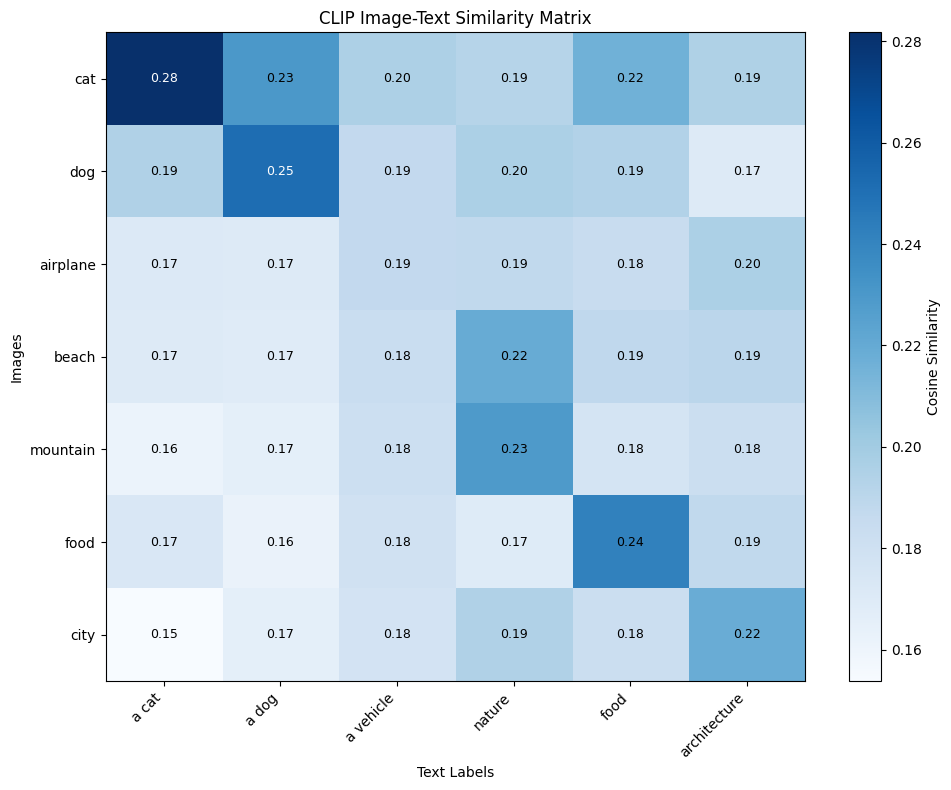

In [13]:
def compute_similarity_matrix(images_dict, text_labels):
    """
    Compute NxM similarity matrix between N images and M text labels.
    
    Returns:
        similarity: (N, M) numpy array
        image_names: list of image names
    """
    image_names = list(images_dict.keys())
    
    # Encode all images
    image_inputs = torch.stack([preprocess(img) for img in images_dict.values()]).to(device)
    text_inputs = clip.tokenize(text_labels).to(device)
    
    with torch.no_grad():
        image_features = model.encode_image(image_inputs)
        text_features = model.encode_text(text_inputs)
        
        # Normalize
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
        # Compute similarity (raw cosine, not softmaxed)
        similarity = (image_features @ text_features.T).cpu().numpy()
    
    return similarity, image_names

# Compute similarity matrix
text_labels = [
    "a cat", "a dog", "a vehicle", "nature", "food", "architecture"
]

similarity, image_names = compute_similarity_matrix(images, text_labels)

# Plot heatmap
plt.figure(figsize=(10, 8))
plt.imshow(similarity, cmap='Blues', aspect='auto')
plt.colorbar(label='Cosine Similarity')

plt.xticks(range(len(text_labels)), text_labels, rotation=45, ha='right')
plt.yticks(range(len(image_names)), image_names)
plt.xlabel('Text Labels')
plt.ylabel('Images')
plt.title('CLIP Image-Text Similarity Matrix')

# Add text annotations
for i in range(len(image_names)):
    for j in range(len(text_labels)):
        plt.text(j, i, f'{similarity[i, j]:.2f}', 
                 ha='center', va='center', fontsize=9,
                 color='white' if similarity[i, j] > 0.25 else 'black')

plt.tight_layout()
plt.show()


## 7. Image-Text Retrieval

Using CLIP embeddings, we can build a simple search system:
- **Text → Image**: Find images matching a text query
- **Image → Text**: Find descriptions matching an image


In [14]:
def text_to_image_search(query, images_dict, top_k=3):
    """
    Find images most similar to a text query.
    """
    image_names = list(images_dict.keys())
    
    # Encode query
    text_input = clip.tokenize([query]).to(device)
    
    # Encode all images
    image_inputs = torch.stack([preprocess(img) for img in images_dict.values()]).to(device)
    
    with torch.no_grad():
        text_features = model.encode_text(text_input)
        image_features = model.encode_image(image_inputs)
        
        # Normalize
        text_features /= text_features.norm(dim=-1, keepdim=True)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        
        # Compute similarities
        similarities = (text_features @ image_features.T)[0].cpu().numpy()
    
    # Sort by similarity
    top_indices = similarities.argsort()[-top_k:][::-1]
    
    return [(image_names[i], similarities[i]) for i in top_indices]

# Text-to-image search demo
queries = [
    "a fluffy pet",
    "a relaxing vacation destination",
    "something you can drive",
    "delicious meal",
]

print("Text-to-Image Search Results:")
print("=" * 60)

for query in queries:
    results = text_to_image_search(query, images, top_k=3)
    print(f"\nQuery: '{query}'")
    for name, score in results:
        print(f"  → {name:12} (similarity: {score:.3f})")


Text-to-Image Search Results:

Query: 'a fluffy pet'
  → cat          (similarity: 0.251)
  → dog          (similarity: 0.238)
  → airplane     (similarity: 0.177)

Query: 'a relaxing vacation destination'
  → beach        (similarity: 0.248)
  → city         (similarity: 0.227)
  → mountain     (similarity: 0.227)

Query: 'something you can drive'
  → cat          (similarity: 0.201)
  → beach        (similarity: 0.200)
  → food         (similarity: 0.195)

Query: 'delicious meal'
  → food         (similarity: 0.238)
  → cat          (similarity: 0.201)
  → dog          (similarity: 0.181)


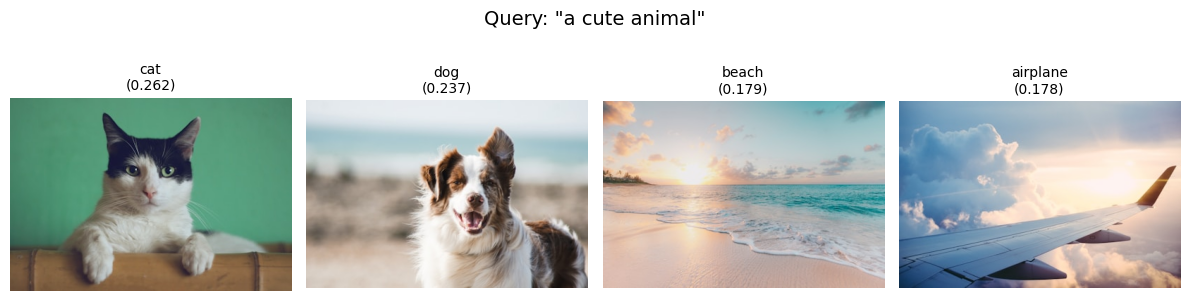

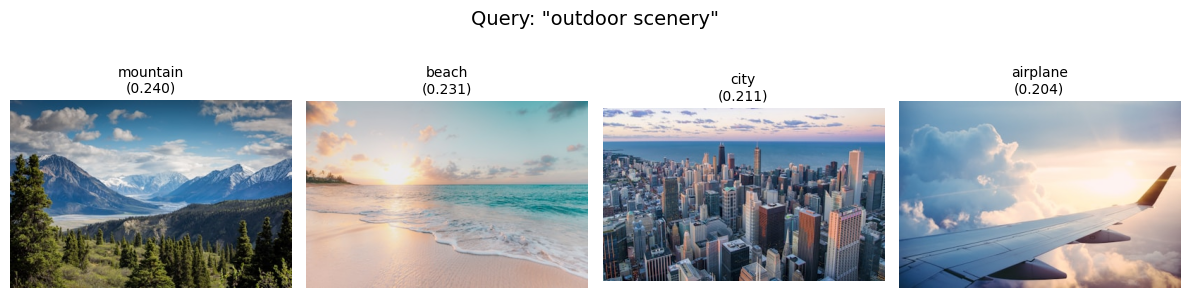

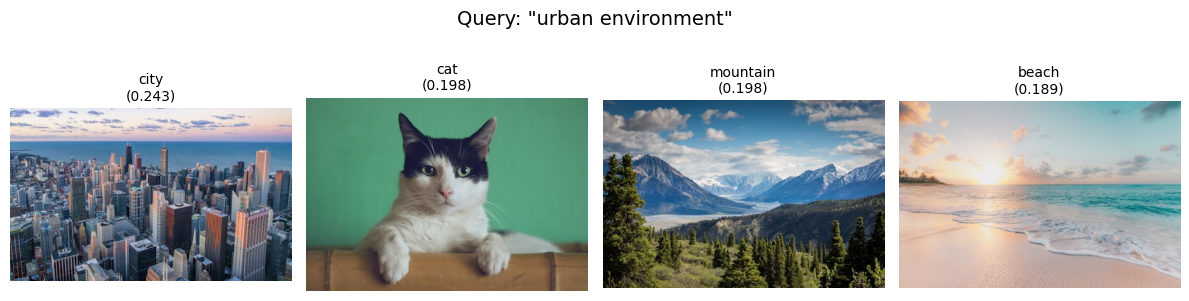

In [15]:
def visualize_search_results(query, images_dict, top_k=4):
    """Visualize text-to-image search results."""
    results = text_to_image_search(query, images_dict, top_k=top_k)
    
    fig, axes = plt.subplots(1, top_k, figsize=(3*top_k, 3.5))
    fig.suptitle(f'Query: "{query}"', fontsize=14)
    
    for i, (name, score) in enumerate(results):
        axes[i].imshow(images_dict[name])
        axes[i].set_title(f'{name}\n({score:.3f})', fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize some searches
visualize_search_results("a cute animal", images)
visualize_search_results("outdoor scenery", images)
visualize_search_results("urban environment", images)


## 8. Contrastive Loss (InfoNCE) from Scratch

Now let's implement the core training objective that makes CLIP work: the **InfoNCE contrastive loss**.

The idea:
- Given a batch of N (image, text) pairs
- Matching pairs should have high similarity
- Non-matching pairs should have low similarity


In [16]:
def clip_contrastive_loss(image_embeddings, text_embeddings, temperature=0.07):
    """
    Compute CLIP's symmetric contrastive loss (InfoNCE).
    
    Args:
        image_embeddings: (N, D) normalized image embeddings
        text_embeddings: (N, D) normalized text embeddings
        temperature: Temperature parameter (lower = sharper distribution)
    
    Returns:
        loss: Scalar loss value
        logits: (N, N) similarity matrix (for visualization)
    """
    # Compute similarity matrix: (N, N)
    logits = (image_embeddings @ text_embeddings.T) / temperature
    
    # Labels: diagonal entries are correct pairs (0, 1, 2, ..., N-1)
    labels = torch.arange(len(logits), device=logits.device)
    
    # Symmetric cross-entropy loss
    loss_i2t = F.cross_entropy(logits, labels)      # image → text
    loss_t2i = F.cross_entropy(logits.T, labels)    # text → image
    
    loss = (loss_i2t + loss_t2i) / 2
    
    return loss, logits


In [17]:
# Demonstrate the loss with our sample images
matched_pairs = [
    ("cat", "a photo of a cat"),
    ("dog", "a photo of a dog"),
    ("car", "a photo of a car"),
    ("beach", "a photo of a beach"),
]

# Filter to available images
matched_pairs = [(name, text) for name, text in matched_pairs if name in images]

# Encode images and texts
batch_images = torch.stack([preprocess(images[name]) for name, _ in matched_pairs]).to(device)
batch_texts = clip.tokenize([text for _, text in matched_pairs]).to(device)

with torch.no_grad():
    image_emb = model.encode_image(batch_images)
    text_emb = model.encode_text(batch_texts)
    
    # Normalize
    image_emb = image_emb / image_emb.norm(dim=-1, keepdim=True)
    text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)

# Compute loss
loss, logits = clip_contrastive_loss(image_emb, text_emb, temperature=0.07)
print(f"Contrastive Loss: {loss.item():.4f}")
print(f"\n(Low loss means good alignment between matched pairs)")


Contrastive Loss: 0.5410

(Low loss means good alignment between matched pairs)


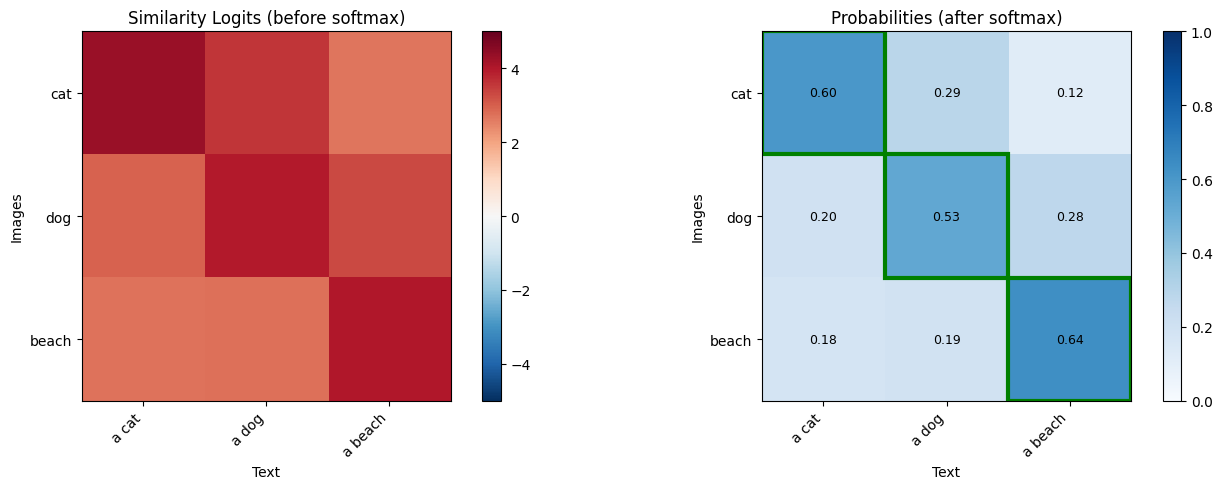

In [18]:
# Visualize the similarity matrix
def visualize_contrastive_matrix(logits, image_names, text_labels):
    """Visualize the NxN similarity matrix from contrastive learning."""
    probs = F.softmax(logits, dim=-1).cpu().numpy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Raw logits
    im1 = ax1.imshow(logits.cpu().numpy(), cmap='RdBu_r', vmin=-5, vmax=5)
    ax1.set_title('Similarity Logits (before softmax)')
    ax1.set_xticks(range(len(text_labels)))
    ax1.set_yticks(range(len(image_names)))
    ax1.set_xticklabels([t.replace('a photo of ', '') for t in text_labels], rotation=45, ha='right')
    ax1.set_yticklabels(image_names)
    ax1.set_xlabel('Text')
    ax1.set_ylabel('Images')
    plt.colorbar(im1, ax=ax1)
    
    # Probabilities
    im2 = ax2.imshow(probs, cmap='Blues', vmin=0, vmax=1)
    ax2.set_title('Probabilities (after softmax)')
    ax2.set_xticks(range(len(text_labels)))
    ax2.set_yticks(range(len(image_names)))
    ax2.set_xticklabels([t.replace('a photo of ', '') for t in text_labels], rotation=45, ha='right')
    ax2.set_yticklabels(image_names)
    ax2.set_xlabel('Text')
    ax2.set_ylabel('Images')
    plt.colorbar(im2, ax=ax2)
    
    # Add annotations
    for i in range(len(image_names)):
        for j in range(len(text_labels)):
            if i == j:
                ax2.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, 
                              fill=False, edgecolor='green', linewidth=3))
            ax2.text(j, i, f'{probs[i, j]:.2f}', ha='center', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

image_names = [name for name, _ in matched_pairs]
text_labels = [text for _, text in matched_pairs]
visualize_contrastive_matrix(logits, image_names, text_labels)


### Training a Tiny CLIP-like Model

To understand contrastive learning better, let's train a tiny model on synthetic data.


In [19]:
class TinyCLIP(nn.Module):
    """
    A tiny CLIP-like model for demonstration.
    Uses simple linear projections instead of full encoders.
    """
    def __init__(self, image_dim, text_dim, embed_dim):
        super().__init__()
        self.image_encoder = nn.Linear(image_dim, embed_dim)
        self.text_encoder = nn.Linear(text_dim, embed_dim)
        # Learnable temperature
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
    
    def forward(self, images, texts):
        # Encode
        image_emb = self.image_encoder(images)
        text_emb = self.text_encoder(texts)
        
        # Normalize
        image_emb = image_emb / image_emb.norm(dim=-1, keepdim=True)
        text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
        
        return image_emb, text_emb, self.logit_scale.exp()

# Create synthetic data: 5 concepts, images and texts of the same concept should match
n_concepts = 5
samples_per_concept = 20
image_dim = 32
text_dim = 32
embed_dim = 16

torch.manual_seed(42)
concept_centers = torch.randn(n_concepts, image_dim)

synthetic_images = []
synthetic_texts = []
labels = []

for concept_id in range(n_concepts):
    center = concept_centers[concept_id]
    for _ in range(samples_per_concept):
        img = center + 0.3 * torch.randn(image_dim)
        synthetic_images.append(img)
        txt = center + 0.1 * torch.randn(text_dim)
        synthetic_texts.append(txt)
        labels.append(concept_id)

synthetic_images = torch.stack(synthetic_images)
synthetic_texts = torch.stack(synthetic_texts)
labels = torch.tensor(labels)

print(f"Synthetic dataset: {len(synthetic_images)} samples, {n_concepts} concepts")


Synthetic dataset: 100 samples, 5 concepts


In [20]:
# Train the tiny CLIP model
tiny_clip = TinyCLIP(image_dim, text_dim, embed_dim)
optimizer = torch.optim.Adam(tiny_clip.parameters(), lr=0.01)

batch_size = 16
n_epochs = 100
losses = []

print("Training TinyCLIP on synthetic data...")
print("-" * 40)

for epoch in range(n_epochs):
    # Random batch
    indices = torch.randperm(len(synthetic_images))[:batch_size]
    batch_images = synthetic_images[indices]
    batch_texts = synthetic_texts[indices]
    
    # Forward pass
    image_emb, text_emb, scale = tiny_clip(batch_images, batch_texts)
    
    # Compute loss
    logits = scale * (image_emb @ text_emb.T)
    batch_labels = torch.arange(batch_size)
    loss_i2t = F.cross_entropy(logits, batch_labels)
    loss_t2i = F.cross_entropy(logits.T, batch_labels)
    loss = (loss_i2t + loss_t2i) / 2
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1:3d}: Loss = {loss.item():.4f}")

print(f"\nFinal loss: {losses[-1]:.4f}")


Training TinyCLIP on synthetic data...
----------------------------------------
Epoch  20: Loss = 1.3382
Epoch  40: Loss = 1.2536
Epoch  60: Loss = 1.2117
Epoch  80: Loss = 1.3318
Epoch 100: Loss = 1.1614

Final loss: 1.1614


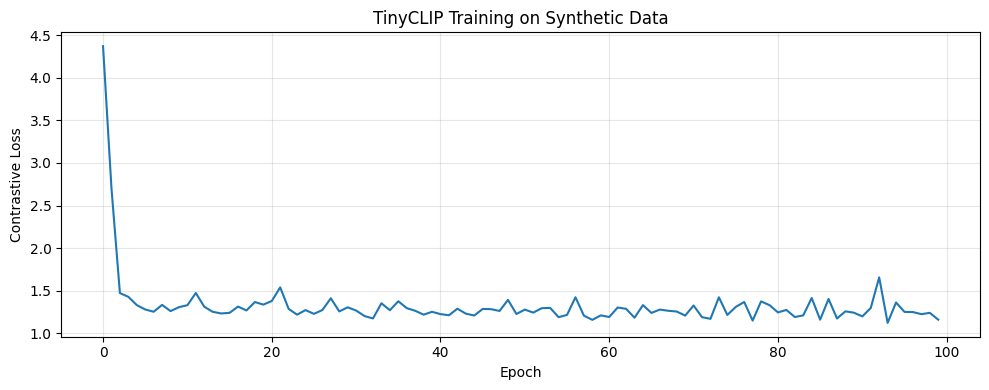

In [21]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Contrastive Loss')
plt.title('TinyCLIP Training on Synthetic Data')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


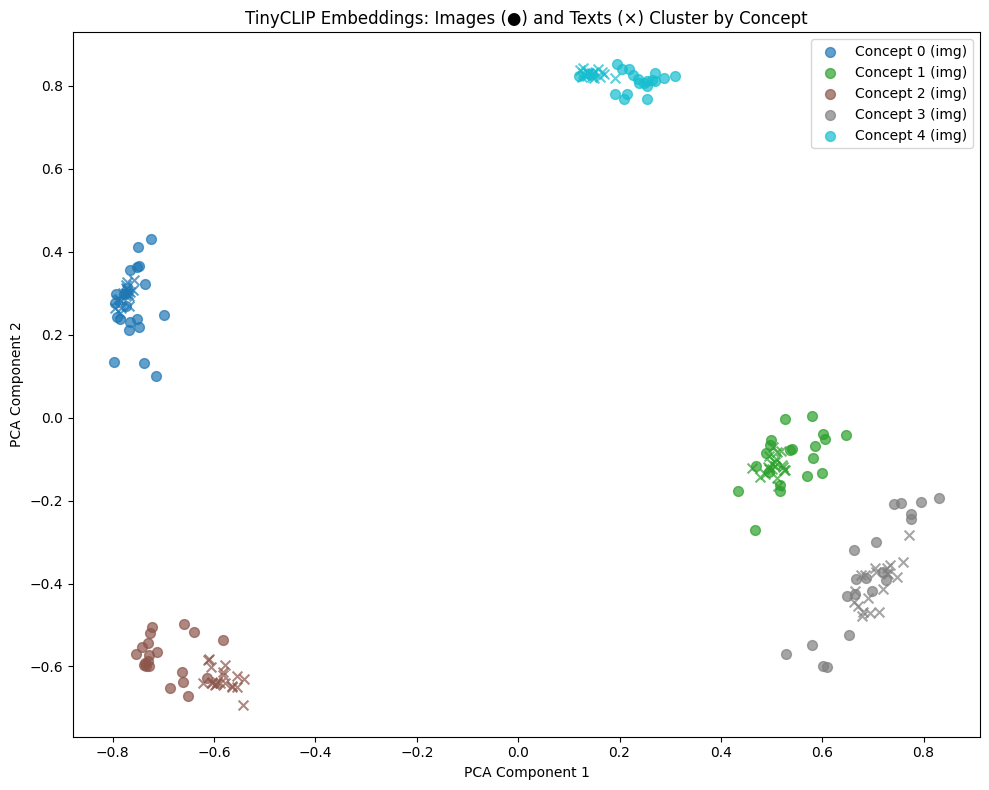

Matching image-text pairs cluster together in embedding space!


In [22]:
# Visualize learned embeddings
from sklearn.decomposition import PCA

with torch.no_grad():
    all_image_emb, all_text_emb, _ = tiny_clip(synthetic_images, synthetic_texts)

# Reduce to 2D for visualization
pca = PCA(n_components=2)
combined = torch.cat([all_image_emb, all_text_emb]).numpy()
combined_2d = pca.fit_transform(combined)

n_samples = len(synthetic_images)
image_2d = combined_2d[:n_samples]
text_2d = combined_2d[n_samples:]

# Plot
plt.figure(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, n_concepts))

for concept_id in range(n_concepts):
    mask = labels.numpy() == concept_id
    plt.scatter(image_2d[mask, 0], image_2d[mask, 1], 
                c=[colors[concept_id]], marker='o', s=50, alpha=0.7,
                label=f'Concept {concept_id} (img)')
    plt.scatter(text_2d[mask, 0], text_2d[mask, 1], 
                c=[colors[concept_id]], marker='x', s=50, alpha=0.7)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('TinyCLIP Embeddings: Images (●) and Texts (×) Cluster by Concept')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print("Matching image-text pairs cluster together in embedding space!")


## 9. Summary

In this notebook, we explored:

1. **CLIP Architecture**: Dual encoders mapping images and text to a shared embedding space.
2. **Zero-Shot Classification**: Classify images into any categories by comparing embeddings.
3. **Prompt Engineering**: The text prompt format significantly affects performance.
4. **Image-Text Retrieval**: Use similarity to search across modalities.
5. **Contrastive Learning**: The InfoNCE loss that trains CLIP to align matching pairs.

**Key Takeaways:**
- CLIP is a **judge**, not a generator — it scores image-text compatibility
- Zero-shot transfer works because of the **shared embedding space**
- Contrastive learning is **self-supervised** — the pairing provides the supervision
- CLIP embeddings power many downstream applications (DALL-E, Stable Diffusion, etc.)


## 10. Exercises

Try these to deepen your understanding:

1. **Custom Classification**: Create your own zero-shot classifier for a domain you care about (e.g., art styles, food types, emotions).

2. **Prompt Optimization**: Find the best prompt template for a specific classification task by trying many variations.

3. **Failure Analysis**: Find images that CLIP consistently misclassifies. What patterns do you notice?

4. **Temperature Sensitivity**: Modify the contrastive loss to use different temperatures. How does it affect training?

5. **Hard Negatives**: In TinyCLIP training, try using "hard negatives" (similar but wrong pairs) instead of random negatives.
